* This notebook was made to explore salinity variation along Tsawwassen to Swartz ferry route

In [1]:
from __future__ import division, print_function
from cStringIO import StringIO
from IPython.core.display import HTML
from salishsea_tools.nowcast import figures
from glob import glob
import datetime
import glob
import os
import arrow
from dateutil import tz
from datetime import datetime, timedelta
from sklearn import linear_model
from pylab import *
from matplotlib.backends import backend_agg as backend
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import netCDF4 as nc
import numpy as np
import pandas as pd
import requests
import math
from scipy import interpolate as interp
import scipy.io as sio

from salishsea_tools import (
    nc_tools,
    viz_tools,
    stormtools,
    tidetools,
)


# Font format
title_font = {
    'fontname': 'Bitstream Vera Sans', 'size': '15', 'color': 'black',
    'weight': 'medium'
}
axis_font = {'fontname': 'Bitstream Vera Sans', 'size': '13'}
%matplotlib inline

In [2]:
def results_dataset(period, grid, results_dir):
    """Return the results dataset for period (e.g. 1h or 1d)
    and grid (e.g. grid_T, grid_U) from results_dir.
    """
    filename_pattern = 'SalishSea_{period}_*_{grid}.nc'
    filepaths = glob(os.path.join(results_dir, filename_pattern.format(period=period, grid=grid)))
    return nc.Dataset(filepaths[0])

In [3]:
run_date = datetime.datetime(2015,8,14)
# Results dataset location
results_home = '/data/dlatorne/MEOPAR/SalishSea/nowcast/'
results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())

In [4]:
def date(year, month, day_start, day_end, period, grid):
    
    day_range = np.arange(day_start, day_end+1)
    day_len = len(day_range)
    files_all = [None] * day_len
    inds = np.arange(day_len)
    
    for i, day in zip(inds, day_range):
        run_date = datetime.datetime(year,month, day)
        results_home = '/data/dlatorne/MEOPAR/SalishSea/nowcast/'
        results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())
        filename = 'SalishSea_' + period + '_' + run_date.strftime('%Y%m%d').lower() + \
        '_' + run_date.strftime('%Y%m%d').lower() + '_' + grid + '.nc'
        file_single = os.path.join(results_dir, filename)
        files_all[i] = file_single

    return files_all

In [5]:
from glob import glob
grid_T_hr = results_dataset('1h', 'grid_T', results_dir)
bathy = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
PNW_coastline = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')
filepath_name = date(run_date.year,run_date.month,run_date.day,run_date.day,'1h','grid_T') 

In [6]:
latitude=grid_T_hr.variables['nav_lat'] 
longitude=grid_T_hr.variables['nav_lon']
sal_hr = grid_T_hr.variables['vosaline']
t, z = 3, 1
sal_hr = np.ma.masked_values(sal_hr[t, z], 0)

# Prepare salinity data

In [7]:
saline=sio.loadmat('/ocean/jieliu/research/meopar/salinity_comparison/data/TWSB/TWSB_TSG20150813.mat') 

In [8]:
def find_dist (q, lon11, lat11, X, Y, bathy, longitude, latitude, saline_nemo_3rd, saline_nemo_4rd):
    k=0
    values =0
    valuess=0
    dist = np.zeros(9)
    weights = np.zeros(9)
    value_3rd=np.zeros(9)
    value_4rd=np.zeros(9)
    regr =linear_model.LinearRegression()
    regr.fit(lon11,lat11);
    regr.coef_

    [x1, j1] = tidetools.find_closest_model_point(lon11[q],regr.predict(lon11[q]),\
                                        X,Y,bathy,lon_tol=0.0052,lat_tol=0.00210,allow_land=False)
    for i in np.arange(x1-1,x1+2):
        for j in np.arange(j1-1,j1+2):
            dist[k]=tidetools.haversine(lon11[q],lat11[q],longitude[i,j],latitude[i,j])
            weights[k]=1.0/dist[k]
            value_3rd[k]=saline_nemo_3rd[i,j]*weights[k]
            value_4rd[k]=saline_nemo_4rd[i,j]*weights[k]
            values=values+value_3rd[k]
            valuess=valuess+value_4rd[k]
            k+=1
            
    return values, valuess, weights

In [9]:
def salinity_fxn(saline):
    struct= (((saline['TWSB_TSG'])['output'])[0,0])['Practical_Salinity'][0,0]##need to modify
    salinity = struct['data'][0,0]
    time = struct['matlabTime'][0,0]
    lonn = struct['longitude'][0,0]
    latt = struct['latitude'][0,0]
    
    a=len(time)
    lon1=np.zeros([a,1])
    lat1=np.zeros([a,1])
    salinity1=np.zeros([a,1])
    run_lower = run_date.replace(hour = 2, minute = 0)#!!more convenient than day,miniute..
    run_upper = run_date.replace(hour= 4, minute = 0)
    for i in np.arange(0,a):
        matlab_datenum = np.float(time[i])
        python_datetime = datetime.datetime.fromordinal(int(matlab_datenum))\
        + timedelta(days=matlab_datenum%1) - timedelta(days = 366)
        if (python_datetime >= run_lower) &(python_datetime < run_upper):
            lon1[i]=lonn[i]
            lat1[i]=latt[i]
            salinity1[i]=salinity[i]        
    mask=lon1[:,0]!=0
    lon1_2_4=lon1[mask]
    lat1_2_4=lat1[mask]
    salinity1_2_4=salinity1[mask]
    lon11=lon1_2_4[0:-1:20]
    lat11=lat1_2_4[0:-1:20]
    salinity11=salinity1_2_4[0:-1:20]
    
    bathy, X, Y = tidetools.get_SS2_bathy_data()
    
    aa=date(run_date.year,run_date.month,run_date.day,run_date.day,'1h','grid_T') 
    date_str = run_date.strftime('%d-%b-%Y') ##create a string based on this date
    tracers=nc.Dataset(aa[0])
    j=int(aa[0][65:67])
    jj=int(aa[0][67:69])
    latitude=tracers.variables['nav_lat'][:] 
    longitude=tracers.variables['nav_lon'][:] 
    saline_nemo = tracers.variables['vosaline']
    saline_nemo_3rd = saline_nemo[2,1, 0:898, 0:398] 
    saline_nemo_4rd = saline_nemo[3,1, 0:898, 0:398]
    
    matrix=np.zeros([len(lon11),9])
    values=np.zeros([len(lon11),1])
    valuess=np.zeros([len(lon11),1])
    value_mean_3rd_hour=np.zeros([len(lon11),1])
    value_mean_4rd_hour=np.zeros([len(lon11),1]) 
    for q in np.arange(0,len(lon11)):
       values[q], valuess[q], matrix[q,:]=find_dist(q, lon11, lat11, X, Y,\
                                     bathy, longitude, latitude, saline_nemo_3rd, saline_nemo_4rd)
       value_mean_3rd_hour[q]=values[q]/sum(matrix[q])
       value_mean_4rd_hour[q]=valuess[q]/sum(matrix[q])

    return lon11, lat11, lon1_2_4, lat1_2_4,\
    value_mean_3rd_hour, value_mean_4rd_hour,\
    salinity11, salinity1_2_4,date_str

In [10]:
# Hides Deprecation warming - needs fixing
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [11]:
# Dictionary of ferry stations - new
ferry_stations = {'Tsawwassen': {'lat': 49.0084,'lon': -123.1281},
                  'Swartz': {'lat': 48.6882,'lon': -123.4102},
                  'Vancouver': {'lat': 49.2827,'lon': -123.1207}}

In [12]:
def salinity_ferry_route(grid_T, grid_B, PNW_coastline, ferry_sal):
    """ plot daily salinity comparisons between ferry observations 
    and model results as well as ferry route with model salinity 
    distribution.
    
    :arg grid_B: Bathymetry dataset for the Salish Sea NEMO model.
    :type grid_B: :class:`netCDF4.Dataset`
    
    :arg PNW_coastline: Coastline dataset.
    :type PNW_coastline: :class:`mat.Dataset`
    
    :arg ferry_sal: saline
    :type ferry_sal: numpy
    
    :returns: fig
    """

    fig, axs = plt.subplots(1, 2, figsize=(15, 8))

    figures.plot_map(axs[1], grid_B, PNW_coastline)
    axs[1].set_xlim(-124.5, -122.5)
    axs[1].set_ylim(48.2, 49.5)
    viz_tools.set_aspect(axs[1],coords='map',lats=latitude)
    cmap=plt.get_cmap('spectral')
    cmap.set_bad('burlywood')
    mesh=axs[1].pcolormesh(longitude[:],latitude[:],sal_hr[:],cmap=cmap)
    cbar=fig.colorbar(mesh)
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='w')
    cbar.set_label('Pratical Salinity', color='white')
    
    axs[1].set_title('Ferry Route: 3am[UTC] 1.5m model result ', **title_font)
 
    bbox_args = dict(boxstyle='square', facecolor='white', alpha=0.7)
    stations=['Tsawwassen','Swartz','Vancouver']
    for stn in stations:
        axs[1].plot(ferry_stations[stn]['lon'], ferry_stations[stn]['lat'], marker='D', \
                    color='white',\
                 markersize=10, markeredgewidth=2)
    axs[1].annotate ('Tsawwassen',(ferry_stations['Tsawwassen']['lon'] + 0.022,\
    ferry_stations['Tsawwassen']['lat'] + 0.052), fontsize=15, color='black', bbox=bbox_args )
    axs[1].annotate ('Swartz',(ferry_stations['Swartz']['lon'] - 0.45,\
    ferry_stations['Swartz']['lat'] - 0.1 ),fontsize=15, color='black', bbox=bbox_args )
    axs[1].annotate ('Vancouver',(ferry_stations['Vancouver']['lon'] - 0.1,\
    ferry_stations['Vancouver']['lat']+ 0.09 ),fontsize=15, color='black', bbox=bbox_args )
    figures.axis_colors(axs[1], 'white')
    
    
    lon11, lat11, lon1_2_4, lat1_2_4,\
    value_mean_3rd_hour, value_mean_4rd_hour,\
    salinity11,salinity1_2_4, date_str = salinity_fxn(saline)
    axs[1].plot(lon11,lat11,'black', linewidth = 4)
    model_salinity_3rd_hour=axs[0].plot(lon11,value_mean_3rd_hour,'DodgerBlue',\
                                    linewidth=2, label='2 am [UTC]')
    model_salinity_4rd_hour=axs[0].plot(lon11,value_mean_4rd_hour,'MediumBlue',\
                                        linewidth=2, label="3 am [UTC]" )
    observation_salinity=axs[0].plot(lon1_2_4,salinity1_2_4,'DarkGreen', linewidth=2, label="Observed")
    axs[0].text(0.25, -0.1,'Observations from Ocean Networks Canada', \
                transform=axs[0].transAxes, color='white')

    axs[0].set_xlim(-124, -123)
    axs[0].set_ylim(0, 30)
    axs[0].set_title('Surface Salinity: ' + date_str, **title_font)
    axs[0].set_xlabel('Longitude', **axis_font)
    axs[0].set_ylabel('Practical Salinity', **axis_font)
    axs[0].legend(loc = 2)
    axs[0].grid()
   

    fig.patch.set_facecolor('#2B3E50')
    figures.axis_colors(axs[0], 'gray')
    
    return fig

# Plot

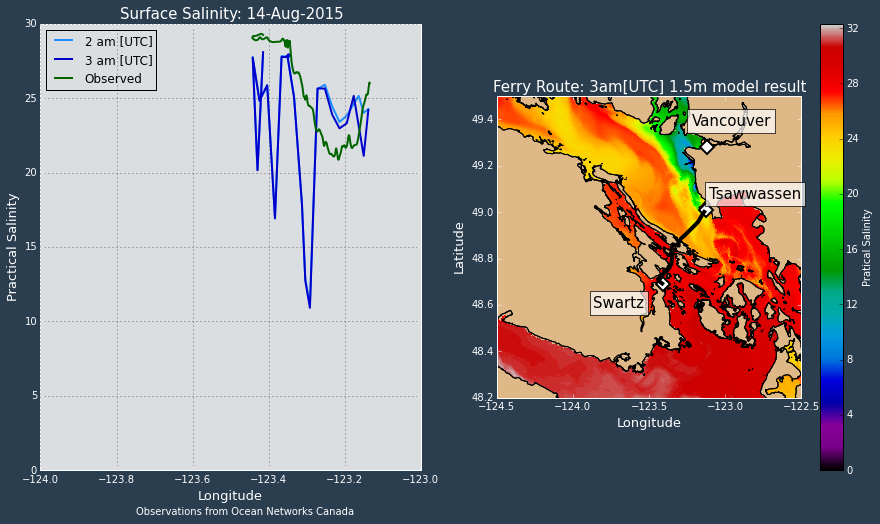

In [14]:
fig = salinity_ferry_route(grid_T_hr, bathy, PNW_coastline, saline)